In [27]:
fileName = 'btcusdt_1h.csv'

#README

* Set file name above, and run all.
* logs.csv will contain the required data



#Imports

##Import Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Utilities

##Helpers

In [29]:
#Utility Class, containing helper functions to find metrics.

class Utility:

  # Calculates drawdown percentage of the given portfolio values
  @staticmethod
  def calculate_drawdown_percentage(portfolio_values):
    max_drawdowns = []
    peak_value = portfolio_values[0]
    for i in range(1, len(portfolio_values)):
        peak_value = max(peak_value,portfolio_values[i])
        drawdown = (peak_value-portfolio_values[i]) / peak_value * 100
        max_drawdowns.append(drawdown)

    return max(max_drawdowns)

  # Generalised function to return required metric
  @staticmethod
  def calculateMetric(df,portfolioValues,metric):
    match metric:
      case 'PNL':
        return portfolioValues[-1]-portfolioValues[0]
      case 'Drawdown':
        return Utility.calculate_drawdown_percentage(portfolioValues)
      case 'PNLByDrawdown':
        return (portfolioValues[-1]-portfolioValues[0])/Utility.calculate_drawdown_percentage(portfolioValues)

  # Computes PNL from signals for the entire timeframe passed
  @staticmethod
  def getCompleteInfo(df,signal_column,initialCash=1000,position=0,entryPrice=0,exitPrice=0,
                      metric='PNL',compound=False,addPortfolio=False,printDrawdown=False,
                      unrealised=False,commission=0.15,investmentAmount=1000,priceColumn='close'):

    portfolio = []
    cash = initialCash
    multipleBuys = False
    multipleSells = False
    for index,row in df.iterrows():
      if compound:
        investmentAmount = cash
      signal = row[signal_column]
      currPrice = row[priceColumn]
      if position==0:
        portfolio.append(cash)
        if signal==1:
          position=1
          entryPrice = currPrice
        elif signal==-1:
          position=-1
          exitPrice = currPrice
      elif position==1:
        if unrealised:
          portfolio.append(cash-investmentAmount+investmentAmount/entryPrice*currPrice)
        else:
          portfolio.append(cash)
        if signal==-1:
          change = investmentAmount/entryPrice*(currPrice-entryPrice)
          cash+=change
          cash-=commission/100*investmentAmount
          position=0
        elif signal==1:
          multipleBuys = True
      elif position==-1:
        if unrealised:
          portfolio.append(cash+investmentAmount-investmentAmount/exitPrice*currPrice)
        else:
          portfolio.append(cash)
        if signal==1:
          change = investmentAmount/exitPrice*(exitPrice-currPrice)
          cash+=change
          cash-=commission/100*investmentAmount
          position=0
        elif signal==-1:
          multipleSells = True
    if multipleBuys:
      print("Your signals attempt to hold more than 1 position")
    if multipleSells:
      print("Your signals attempt to sell more than 1 position")
    if addPortfolio:
      df['portfolio'] = portfolio
    if printDrawdown:
      print(Utility.calculate_drawdown_percentage(portfolio))
    return Utility.calculateMetric(df,portfolio,metric)

  # Computes Sharpe Ratio
  @staticmethod
  def calculate_sharpe_ratio(df, risk_free_rate):
    df['Daily Return'] = df['portfolio'].pct_change(1)
    Sharpe_Ratio = (df['Daily Return'].mean() - risk_free_rate) / df['Daily Return'].std()
    A_SharpeRatio = (252 ** 0.5) * Sharpe_Ratio
    df.drop(columns = ['Daily Return'])
    return A_SharpeRatio

  # Computes Sortino Ratio
  @staticmethod
  def calculate_sortino_ratio(df, risk_free_rate, weights = [1.0]):
    returns = df['portfolio'].pct_change(1).dropna()
    negative_returns = returns[returns < 0]
    downside_std = np.std(negative_returns)
    exp_rets = returns.mean()
    mean = np.dot(exp_rets, weights)
    excess_return = mean - risk_free_rate
    sortino_ratio = excess_return / downside_std
    return sortino_ratio

##Plotter

In [30]:
# Plotter Class, for data visualisation

class Plotter:

  def __init__(self,figSize=(10,6)):
    self.figureSize = figSize

  def InitialiseFields(self):
    self.numberOfTrades = 0
    self.numberOfWinningTrades = 0
    self.numberOfLosingTrades = 0
    self.averageWinningTrade = 0.0
    self.averageLosingTrade = 0.0
    self.maxWinningTrade = 0.0
    self.maxLosingTrade = 0.0
    self.averageHoldOut = 0.0
    self.lastPrice = 0.0
    self.signal_column = 'signals'
    self.initialCash = 1000
    self.cash = self.initialCash
    self.position = 0
    self.portfolio = []
    self.count = 0
    self.maxDrawDown = 0.0
    self.sharpeRatio = 0.0
    self.sortinioRatio=0.0
    self.priceColumn = 'close'
    self.investmentAmount=1000
    self.startingCapital = self.initialCash
    self.commision=0.15

  # Plots PNLs for the given timeframe
  def PlotPNL(self,df,signalName,windowSize=500,compound=False,plotName='',threshold=0.0,printMaxValue=False,printFinalPortfolio=False, stopLoss = float('inf'), printDrawdown=False):
    self.InitialiseFields()
    if compound:
      Utility.getCompleteInfo(df,signalName,addPortfolio=True,compound=True, printDrawdown = printDrawdown)
    else:
      Utility.getCompleteInfo(df,signalName,addPortfolio=True,compound=False, printDrawdown = printDrawdown)
    plt.figure(figsize=self.figureSize)
    plt.plot(df['Index'], df['portfolio'], label='Portfolio')
    plt.xlabel('Time')
    plt.ylabel('Portfolio')

    stopLossPrint = 'None'
    suffix = 'Window = ' + str(windowSize) +', Threshold = ' + str(threshold)
    if(stopLoss == float('inf')):
      suffix = suffix+', No Stoploss'
    else:
      suffix = suffix + ', Stoploss = '+str(stopLoss)

    if compound:
      plt.title('Portfolio compound Values Over Time\n' + suffix)
    else:
      plt.title('Portfolio static values Over Time\n' + suffix)
    if printMaxValue:
      print(max(df['portfolio']))
    if printFinalPortfolio:
      print(df.iloc[len(df)-1]['portfolio'])
    plt.legend()
    plt.grid(True)
    plt.show()

myPlotter = Plotter()

#Strategies

In [31]:
# Base Strategy Class, containing functionalities and fields common for strategies

class Strategy:
  def __init__(self,strategyNumber=0):
    self.signalsGenerated=False
    self.strategyNumber = strategyNumber

  def getData(self,df=pd.DataFrame()):
    self.data = df

  def getSignals(self):
    return self.data['signals'+str(self.strategyNumber)]

  def generateSignals(self):
    pass

  def execute(self):
    if self.signalsGenerated:
      pass
    else:
      self.signalsGenerated=True
      self.generateSignals()

##Keltner Channel

In [32]:
class KeltnerChannel(Strategy):
  """
    Keltner channels, similar to Bollinger bands and moving average envelopes are based out of volatility based bands wherein
    the metric used for volatility is ATR i.e Average True Range.
  """
  def __init__(self,strategyNumber=0,period=30,multiplier=3,atrLength=14,exp=True):
    """
      The 3 essential parameters for this strategy include:
      1. Smoothing (Simple/Exponential moving average) window to use as the base line
      2. Multiplier to determine the level of deviation at which trades are executed
      3. Length of ATR window to determine the volatility metric
    """
    super().__init__(strategyNumber=strategyNumber)
    self.period = period
    self.multiplier = multiplier
    self.atrLength = atrLength
    self.exp = exp

  def calcESMA(self, column="close"):
    if self.exp == True:
      return self.data[column].ewm(span=self.period, adjust=False).mean()
    else:
      return self.data[column].rolling(window=self.period).mean()

  def generateSignals(self):
    self.data["ma"] = self.calcESMA()
    self.data['High-Low'] = self.data['high'] - self.data['low']
    self.data['High-PrevClose'] = np.abs(self.data['high'] - self.data['close'].shift(1))
    self.data['Low-PrevClose'] = np.abs(self.data['low'] - self.data['close'].shift(1))
    self.data['TrueRange'] = self.data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    self.data["rangema"] = self.data['TrueRange'].rolling(window=self.atrLength).mean()
    self.data["upper"] = self.data["ma"] + self.data["rangema"]*self.multiplier
    self.data["lower"] = self.data["ma"] - self.data["rangema"] *self.multiplier
    self.data["crossUpper"] = 0
    self.data["crossLower"] = 0
    self.data["bprice"] = 0
    self.data["sprice"] = 0
    self.data["BCond"] = 0
    self.data["SCond"] = 0  # Same as cross upper and cross lower(unless there are nan values, none in our case)
    self.data["CancelBCond"] = 0
    self.data["CancelSCond"] = 0
    for i in range(1,len(self.data)):
      self.data.loc[i,"crossUpper"] = int(self.data.loc[i-1, "close"]< self.data.loc[i-1, "upper"] and self.data.loc[i,"close"]>self.data.loc[i,"upper"])
      self.data.loc[i,"crossLower"] = int(self.data.loc[i-1, "close"] > self.data.loc[i-1, "lower"] and self.data.loc[i,"close"]<self.data.loc[i,"lower"])
      self.data.loc[i,"bprice"] = self.data.loc[i,"high"] + self.data.loc[:i,"high"].min() if self.data.loc[i,"crossUpper"] == 1 else self.data.loc[i-1,"bprice"]
      self.data.loc[i,"sprice"] = self.data.loc[i,"low"] - self.data.loc[:i,"low"].min() if self.data.loc[i,"crossLower"] == 1 else self.data.loc[i-1,"bprice"]
      self.data.loc[i,"BCond"] = self.data.loc[i,"close"]>self.data.loc[i,"upper"]
      self.data.loc[i,"SCond"] = self.data.loc[i,"close"]<self.data.loc[i,"lower"]
      self.data.loc[i,"CancelBCond"] = self.data.loc[i,"BCond"] and (self.data.loc[i,"close"]<self.data.loc[i,"ma"] or self.data.loc[i,"high"]>=self.data.loc[i,"bprice"])
      self.data.loc[i, "CancelSCond"] = self.data.loc[i,"SCond"] and (self.data.loc[i,"close"]>self.data.loc[i,"ma"] or self.data.loc[i,"low"]<=self.data.loc[i,"sprice"])
    position = 0
    column = 'signals'+str(self.strategyNumber)
    self.data[column] = 0
    for i in range(20,len(self.data)):
      if self.data.loc[i,"BCond"] == 1:
        if position != 1:
          self.data.loc[i,column] = 1
          position +=1
      elif self.data.loc[i,"SCond"]==1:
        if position != -1:
          self.data.loc[i,column] = -1
          position -= 1
      elif self.data.loc[i,"CancelBCond"] == 1 and position == 1:
        self.data.loc[i,column] = -1
        position -=1
      elif self.data.loc[i,"CancelSCond"] == 1 and position == -1:
        self.data.loc[i,column] = 1
        position +=1
      else:
        self.data.loc[i,column] = 0
    self.data.drop(columns=['ma','High-Low','High-PrevClose', 'Low-PrevClose', 'TrueRange', 'rangema', 'upper', 'lower', 'crossUpper', 'crossLower', 'bprice', 'sprice', 'BCond', 'SCond', 'CancelBCond', 'CancelSCond'],inplace=True)

##VWAP

In [33]:
class VWAP(Strategy):
  """
    VWAP - Volume Weighted Average Price acts as a metric to identify the price at which the market participants perceive a
    financial asset to be it, by taking into account the trading activity(in terms of volume) at different times and prices.
  """
  def __init__(self, strategyNumber=0,window=1000):
    super().__init__(strategyNumber=strategyNumber)
    self.window = window

  def generateSignals(self):
    self.window = 1000
    column = 'signals'+str(self.strategyNumber)
    self.data["vwap"] = self.data["close"]
    self.data["cumvolprice"] = 0
    self.data["cumvol"]=0
    for i in range(self.window, len(self.data)):
      df2 = self.data[i-self.window:i].copy(deep=True)
      # print(data)
      # print(df["volume"].cumsum())
      self.data.loc[i,"cumvol"] = (df2["volume"].cumsum())[i-1]
      self.data.loc[i,"cumvolprice"] = ((df2['volume'] * (df2['high'] + df2['low'] + df2['close'] ) /3).cumsum())[i-1]
      self.data.loc[i,"vwap"] = self.data.loc[i,"cumvolprice"] / self.data.loc[i,"cumvol"]

    position = 0
    self.data[column] = 0
    for i in range(self.window,len(self.data)):
      if self.data.loc[i,"vwap"] < self.data.loc[i,"close"] :
        if position != 1:
          self.data.loc[i,column] = 1
          position +=1
      elif self.data.loc[i,"vwap"] > self.data.loc[i,"close"]:
        if position != -1:
          self.data.loc[i,column] = -1
          position -= 1
      else:
        self.data.loc[i,column] = 0

    self.data.drop(columns=['vwap','cumvolprice','cumvol'],inplace=True)

##CMF

In [34]:
class CMF(Strategy):
  """
    Reference Paper : https://www.mdpi.com/2227-7390/10/12/2037
    The Chaikin Money Flow Indicator was used in order to quantify buying pressure and selling pressure in the market
    by comparing the relative deviation of the close price with respect to the high and low and multiplying with the volume.
    A smoothened average of this is used to give the sentiment of the market in the given time window which is of more
    importance in cryptocurrencies which is considered more sentiment driven than stock markets and tends to have more extreme
    trends and knee jerk reactions.
  """
  def __init__(self,strategyNumber=0,threshold=0):
    super().__init__(strategyNumber=strategyNumber)
    self.threshold = threshold

  def generateSignals(self):
    df_hour = self.data.copy()
    df_hour["datetime"] = pd.to_datetime(df_hour["datetime"])
    df_hour.set_index("datetime", inplace = True)

    df_hour.shape

    # Resampling to daily  frequency
    df_day = pd.DataFrame()
    df_day['open'] = df_hour.resample("D").open.first()
    df_day['close'] = df_hour.resample("D").close.last()
    df_day['high']=df_hour.resample("D").high.max()
    df_day['low'] = df_hour.resample("D").low.min()
    df_day['volume'] = df_hour.resample("D").volume.sum()
    df_day.reset_index(inplace=True)

    df_hour.reset_index(inplace=True)
    signals = np.zeros(df_day.shape[0])
    MFV = df_day.volume*(2*df_day.close - df_day.low - df_day.high)/(df_day.high - df_day.low)
    res = MFV.rolling(20).sum()/df_day.volume.rolling(20).sum()
    pos = 0
    for i in range(signals.shape[0]-1):
        if res[i] > self.threshold and pos != 1:
            signals[i+1] = 1
            pos += 1
        elif res[i] < -self.threshold and pos != -1:
            signals[i+1] = -1
            pos -= 1
    df_day['signals'] = signals

    signals1 = np.zeros(self.data.shape[0])
    j = 0
    for i in range(self.data.shape[0]-1):
      if df_hour.datetime.iloc[i+1].day != df_hour.datetime.iloc[i].day:
        signals1[i] = df_day.signals[j]
        j+=1
    self.data['signals'+str(self.strategyNumber)] = signals1

#Combiner

## Combinations

In [35]:
# Combination Utility Class, containing various logics for weight combination and selection

class Combination:

  # Gets Metric Values for all the past windows, weights them exponentially, with highest weight to recentmost.
  # Selects the strategy with best weight
  @staticmethod
  def getExpDecayMax(weights, windowMetrics, decayFactor):
    newList = []
    for i in range(len(weights)):
      aymanFactor = 0.8
      sum = 0
      for j in range(len(windowMetrics)-1,-1,-1):
        sum = sum + windowMetrics[j][i]*aymanFactor
        aymanFactor = aymanFactor*0.8
      newList.append(sum)

    maxWtInd = 0
    maxWt = float('-inf')
    for i in range(len(weights)):
      if(newList[i]>maxWt):
        maxWtInd = i
        maxWt = newList[i]

    res = []
    for i in range(len(weights)):
      if i==maxWtInd:
        res.append(1)
      else:
        res.append(0)
    return res

  # Gets Metric Values for all the past windows, weights them exponentially, with highest weight to recentmost.
  # Selects the combination (weighted sum of positions).
  @staticmethod
  def getExpDecayComb(weights, windowMetrics, decayFactor):
    newList = []
    for i in range(len(weights)):
      sum = 0
      for j in range(len(windowMetrics)-1,-1,-1):
        sum = sum + windowMetrics[j][i]*decayFactorFactor
        decayFactorFactor = decayFactorFactor*0.8
      newList.append(sum)
    return Combination.Normalise(newList)

  # Normalises the metrics by dividing by the maximum absolute value
  @staticmethod
  def getNormal(strategyMetrics):
    maxAbsProfit = max([abs(x) for x in strategyMetrics])
    for i in range(len(strategyMetrics)):
        strategyMetrics[i] = strategyMetrics[i]/maxAbsProfit
    return strategyMetrics

  # Returns the strategy having the best cumulative metric value
  @staticmethod
  def getBest(strategyMetrics,weights):
    maxProfit = -float('-inf')
    for i in range(len(strategyMetrics)):
      maxProfit = abs(max(maxProfit,strategyMetrics[i]))

    normalFactor = 1/maxProfit

    for i in range(len(weights)):
      weights[i] = weights[i] + strategyMetrics[i]*normalFactor

    maxWtInd = 0
    maxWt = float('-inf')
    for i in range(len(weights)):
      if(weights[i]>maxWt):
        maxWtInd = i
        maxWt = weights[i]

    res = []
    for i in range(len(weights)):
      if i==maxWtInd:
        res.append(1)
      else:
        res.append(0)
    return res

  # Cumulative Sum of metric with highest weight to recentmost
  @staticmethod
  def getLatest(weights,windowMetrics):
    newList = []
    for i in range(len(weights)):
      sum = 0
      cur = 1
      for j in range(len(windowMetrics)-1,-1,-1):
        sum = sum + windowMetrics[j][i]/cur
        cur = cur+1
      newList.append(sum)

    maxWtInd = 0
    maxWt = float('-inf')
    for i in range(len(weights)):
      if(newList[i]>maxWt):
        maxWtInd = i
        maxWt = newList[i]

    res = []
    for i in range(len(weights)):
      if i==maxWtInd:
        res.append(1)
      else:
        res.append(0)
    return res

  # Normalises the metrics
  @staticmethod
  def Normalise(strategyPerformances):
    # if min(strategyPerformances)<0:
    minPerformance = min(strategyPerformances)
    strategyPerformances = [strategyPerformance-minPerformance for strategyPerformance in strategyPerformances]
    total = sum(strategyPerformances)
    strategyPerformances = [s/total for s in strategyPerformances]
    return strategyPerformances

##Helpers

In [36]:
# Contains Utility Functions for Combiner Class

class CombinerUtility:

  # Gets the required window
  @staticmethod
  def GetWindow(index,window):
    return range(index,index+window)

  # Gets dataframe of the required window
  @staticmethod
  def GetWindowDataFrame(df, index, window):
    window = min(len(df)-index,window)
    return df.iloc[CombinerUtility.GetWindow(index,window)]

  # Update Strategy Positions for a given window
  @staticmethod
  def UpdateCumSums(df,startingIndex,window,cumSums,signal_column='signals'):
    for w in range(window):
      for k in range(len(cumSums)):
        cumSums[k]+= df.iloc[startingIndex+w][signal_column+str(k)]
    return cumSums

  # Update Strategy Positions for a given Index
  @staticmethod
  def UpdateCumSumsAtIndex(df,index,cumSums,indices,signal_column='signals'):
    for k in range(len(cumSums)):
      cumSums[k]+=df.iloc[index][signal_column+str(str(indices[k]))]
    return cumSums

  # Get required metrics for all strategies of a given window
  @staticmethod
  def GetStrategyMetrics(df,startingIndex,window,numOfStrategies,currentCash,cumSums,entryPrices,exitPrices,signal_column='signals', metric='PNL'):
    metrics = []
    for i in range(numOfStrategies):
      metrics.append(Utility.getCompleteInfo(CombinerUtility.GetWindowDataFrame(df,startingIndex,window),signal_column+str(i),initialCash=currentCash,position=cumSums[i],entryPrice=entryPrices[i],exitPrice=exitPrices[i],metric=metric, unrealised=True))
    return metrics

  # Get weights by choosing a combination type
  @staticmethod
  def GetMetricWeights(df,startingIndex,window,numOfStrategies,currentCash,cumSums,entryPrices,exitPrices,metric,weights,windowMetrics, calculationType='Standard',decayFactor=0.8):
    strategyMetrics = CombinerUtility.GetStrategyMetrics(df,startingIndex,window,numOfStrategies,currentCash,cumSums,entryPrices,exitPrices,metric=metric,signal_column='signals')
    windowMetrics.append(strategyMetrics.copy())

    if metric=='Drawdown':
      strategyMetrics = [1/(0.1+x) for x in strategyMetrics]

    match calculationType:
      case 'Standard':
        return Combination.Normalise(strategyMetrics)
      case 'ExpDecayComb':
        return Combination.getExpDecayMax(weights,windowMetrics,decayFactor)
      case 'ExpDecayMax':
        return Combination.getExpDecayComb(windowMetrics,decayFactor)
      case 'Normal':
        return Combination.getNormal(strategyMetrics)
      case 'Best':
        return Combination.getBest(strategyMetrics,weights)
      case 'Latest':
        return Combination.getLatest(weights, windowMetrics)

  # Get final position after combination
  @staticmethod
  def GetPositionByCumSums(cumSums,weights,thresh=0):
    position = 0
    for k in range(len(cumSums)):
      position+=weights[k]*cumSums[k]
    if position>thresh:
      return 1
    elif position<-thresh:
      return -1
    else:
      return 0

  @staticmethod
  def Sign(x):
    if x>0:
      return 1
    elif x<0:
      return -1
    else:
      return 0

  # Update entry and exit prices at a given index
  @staticmethod
  def UpdatePricesAtIndex(df,index,cumSums,entryPrices,exitPrices,signal_column='signals',priceColumn='close'):
    price = df.iloc[index][priceColumn]
    for k in range(len(cumSums)):
      if cumSums[k]==1 and df.iloc[index][signal_column+str(k)]==1:
        entryPrices[k] = price
      elif cumSums[k]==-1 and df.iloc[index][signal_column+str(k)]==-1:
        exitPrices[k] = price
    return entryPrices,exitPrices

## Combine

With cryptocurrencies being a developing market, it is of utmost importance to manage risks and stop losses. While sensitive stop losses work well on less noisy developed markets, risk management for cryptocurrencies(based on results of BTC, ETH, LTC, ADA on 2018-2023) is optimal done by dynamic performance based strategies and not static stop losses to make use of the current market dynamics to a greater extent and avoid loss making strategies by minimising their respective weights

With average profit in winning trades being more than 4 times that of losing trades, the current risk reward ratio is above industry standard of 2.
With an average gain per profitable trade at ~62%, we further make our strategy more robust by adding a stop loss condition such that even in the worst possible case(maximum drawdown), our average profitable trade will be having a reward of > 2:1

In [37]:
# Combiner class, combines given strategies and executes to get combined signals

class Combiner:

  def __init__(self, strategyList):
    self.strategyList = strategyList
    self.strategyNumbers = [strategy.strategyNumber for strategy in self.strategyList]
    self.executeStrategies()
    self.df = pd.DataFrame()

  def setData(self,data):
    self.df = data

  # Run all strategies
  def executeStrategies(self):
    for strategy in self.strategyList:
      strategy.execute()

  # Runs the strategy combination based on the specified combination parameters
  def execute(self,combineType = 'Standard', metric='PNL',threshold = 0, window = 500,decayFactor = 0.8, startingCapital=1000, addStopLoss = False, stopLoss=0.1,signal_column='signals', priceColumn='close',trailingStopLoss=False):

    currentCash = startingCapital
    cumSums = [0]*len(self.strategyList)
    entryPrices = [0]*len(self.strategyList)
    exitPrices = [0]*len(self.strategyList)
    weights = [1/len(self.strategyList)]*len(self.strategyList)
    windowWeights = [weights.copy()]
    position = 0
    strategyEntryPrice = 0
    strategyExitPrice = 0
    maximumEntryPrice = 0

    signals = [0]*window

    for i in range(window,len(self.df),window):
      weights = CombinerUtility.GetMetricWeights(self.df,i-window,window,len(self.strategyList),currentCash,cumSums,entryPrices,exitPrices,metric,weights,windowWeights,calculationType = combineType,decayFactor = decayFactor)
      windowWeights.append(weights.copy())
      for j in range(i-window,min(i,len(self.df))):
        cumSums = CombinerUtility.UpdateCumSumsAtIndex(self.df,j,cumSums,self.strategyNumbers)
        entryPrices,exitPrices = CombinerUtility.UpdatePricesAtIndex(self.df,j,cumSums,entryPrices,exitPrices)
      cumSumsCopy = cumSums.copy()
      for w in range(min(i+window,len(self.df))-i):
        signal=0
        stopLossCheck=False
        if trailingStopLoss:
          stopLossPrice = maximumEntryPrice
        else:
          if position==1:
            stopLossPrice = strategyEntryPrice
          elif position==-1:
            stopLossPrice = strategyExitPrice

        if addStopLoss:
          if position==1 and self.df.iloc[i+w-1][priceColumn]<=(1-stopLoss)*stopLossPrice:
              signal=-1
              stopLossCheck=True
          elif position==-1 and self.df.iloc[i+w-1][priceColumn]>=(1+stopLoss)*stopLossPrice:
              signal=1
              stopLossCheck=True
        if not addStopLoss or not stopLossCheck:
          newPosition = CombinerUtility.GetPositionByCumSums(cumSumsCopy,weights,threshold)
          cumSumsCopy = CombinerUtility.UpdateCumSumsAtIndex(self.df,i+w,cumSumsCopy,self.strategyNumbers)
          signal = CombinerUtility.Sign(newPosition-position)
        signals.append(signal)
        currentCash += -1*signal*self.df.iloc[i+w][priceColumn]
        position += signal
        if position==1 and signal==1:
          strategyEntryPrice = self.df.iloc[i+1][priceColumn]
          maximumEntryPrice = strategyEntryPrice
        elif position==-1 and signal==-1:
          strategyExitPrice = self.df.iloc[i+w][priceColumn]
          maximumEntryPrice = strategyExitPrice
        elif position==1 and signal==0:
          maximumEntryPrice = max(maximumEntryPrice,strategyEntryPrice)
        elif position==-1 and signal==0:
          maximumEntryPrice = min(maximumEntryPrice,strategyExitPrice)
    self.df[signal_column] = signals


#Handler

In [38]:
class Handler:

  def __init__(self,strategyList):
    self.data = pd.DataFrame()
    self.strategyList = strategyList

  def readData(self, inputFile='btcusdt_1h.csv'):
    self.data = pd.read_csv(inputFile)
    self.data['Index'] = range(len(self.data))

  def getData(self):
    return self.data

  def setStrategyData(self):
    for strategy in self.strategyList:
      strategy.getData(self.data)

  def setCombinerData(self):
    self.combiner.setData(self.data)

  def createCombiner(self):
    self.combiner = Combiner(self.strategyList)

  def runCombiner(self,combineType = 'Standard', metric='PNL',threshold = 0, window = 500,decayFactor = 0.8, startingCapital=1000, addStopLoss = False, stopLoss=0.1,signal_column='signals', priceColumn='close'):
    self.combiner.execute(combineType=combineType, metric = metric, threshold = threshold, window = window, decayFactor = decayFactor, startingCapital=startingCapital, addStopLoss=addStopLoss, stopLoss=stopLoss, signal_column=signal_column, priceColumn = priceColumn)

  def generateLogs(self,outputFile = 'logs.csv'):
    self.data[['Index','datetime','open','high','low','close','volume','signals']].to_csv(outputFile,encoding='utf-8',index=False)

  def run(self,combineType = 'Standard', metric='PNL',threshold = 0, window = 500,decayFactor = 0.8, startingCapital=1000, addStopLoss = False, stopLoss=0.1,signal_column='signals', priceColumn='close'):
    self.setStrategyData()
    self.createCombiner()
    self.setCombinerData()
    self.runCombiner(combineType=combineType, metric = metric, threshold = threshold, window = window, decayFactor = decayFactor, startingCapital=startingCapital, addStopLoss=addStopLoss, stopLoss=stopLoss, signal_column=signal_column, priceColumn = priceColumn)



#Run

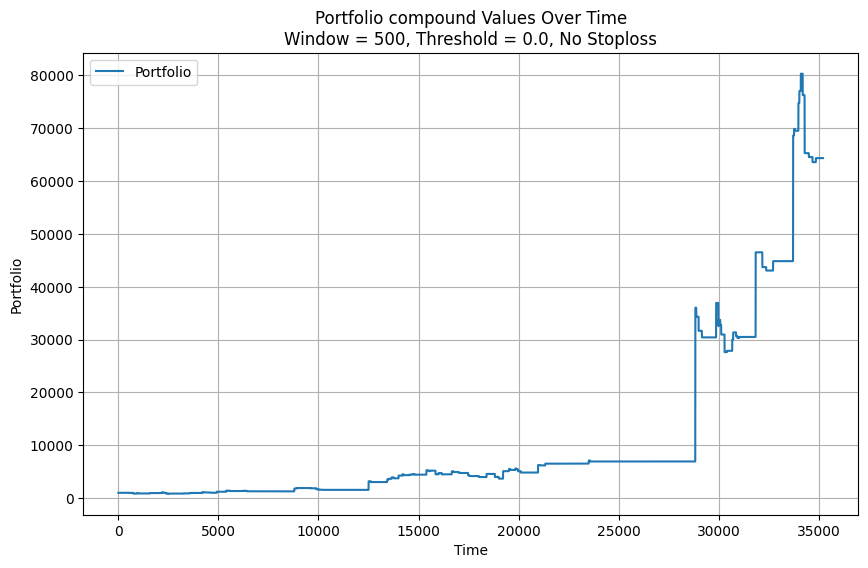

In [39]:
myKeltner = KeltnerChannel(strategyNumber=0)
myCMF = CMF(strategyNumber=1)

myHandler = Handler([myKeltner,myCMF])
myHandler.readData(inputFile=fileName)
myHandler.run(window=500,threshold=0.3)
myHandler.generateLogs()
logs = myHandler.getData()
myPlotter.PlotPNL(logs,'signals',compound=True)
